## City Hotel Weekly Visitors Prediction
Predict number of city hotel visitor per week based on 3 weeks history

In [1]:
# import all depedencies

import matplotlib.pyplot as plt
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Read Data 

In [2]:
# read data from csf file
data = pd.read_csv('data/hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Find visitor data by using *is_canceled* flag, 0 means "not canceled".

In [3]:
# Get data that not canceled
df = data[data['is_canceled'] == 0].drop(columns=['is_canceled'])

In [4]:
# find coresponding number of city hotel visitors per week to use as dataset
data = df[df['hotel'] == 'City Hotel'].groupby(['arrival_date_year','arrival_date_week_number']).count()['hotel']

## Preprocess data for modelling

In [5]:
# helper function to prepare data
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [11]:
# prepare data for modelling
dataset = data.values
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0]
                                , 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Building Model
Model is built using LSTM on Keras with Tensorflow backend

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Train on 73 samples
Epoch 1/100
73/73 - 3s - loss: 142841.1876
Epoch 2/100
73/73 - 0s - loss: 48004.8692
Epoch 3/100
73/73 - 0s - loss: 7041.6934
Epoch 4/100
73/73 - 0s - loss: 7138.1848
Epoch 5/100
73/73 - 0s - loss: 6479.8951
Epoch 6/100
73/73 - 0s - loss: 6828.3271
Epoch 7/100
73/73 - 0s - loss: 6747.4261
Epoch 8/100
73/73 - 0s - loss: 6366.8749
Epoch 9/100
73/73 - 0s - loss: 6752.3475
Epoch 10/100
73/73 - 0s - loss: 6138.5184
Epoch 11/100
73/73 - 0s - loss: 6570.8805
Epoch 12/100
73/73 - 0s - loss: 6009.6210
Epoch 13/100
73/73 - 0s - loss: 6605.9181
Epoch 14/100
73/73 - 0s - loss: 5958.3341
Epoch 15/100
73/73 - 0s - loss: 6059.6810
Epoch 16/100
73/73 - 0s - loss: 6043.5575
Epoch 17/100
73/73 - 0s - loss: 5695.2544
Epoch 18/100
73/73 - 0s - loss: 6382.0817
Epoch 19/100
73/73 - 0s - loss: 6326.4232
Epoch 20/100
73/73 - 0s - loss: 6337.1703
Epoch 21/100
73/73 - 0s - loss: 5869.4673
Epoch 22/100
73/73 - 0s - loss: 5929.2679
Epoch 23/100
73/73 - 0s - loss: 6845.7115
Epoch 24/100
73/73 -

## Evaluate Model Perfomance
Model perfomance is measured using RMSE and prediction for traning and testing can be seen through line graph.

In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 72.62 RMSE
Test Score: 43.45 RMSE


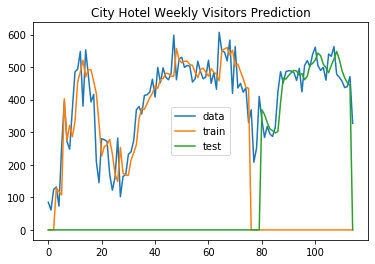

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.zeros(trainPredictPlot.shape)
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.zeros(trainPredictPlot.shape)
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict[:,0]
# plot baseline and predictions
plt.plot(dataset, label='data')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot, label='test')
plt.title("City Hotel Weekly Visitors Prediction")
plt.legend()
plt.show()